In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import time
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:

df = joblib.load("cleaned_data.pkl")

In [21]:
from sklearn.preprocessing import LabelEncoder


df_encoded = df

# Encode categorical columns individually (without loop)
df_encoded['category'] = LabelEncoder().fit_transform(df['category'])
df_encoded['promotional_language'] = df['promotional_language'].astype(int)  # Convert boolean to int

# Optionally: encode 'text_' only if you're doing ID-style encoding (⚠️ not for NLP models)
# df_encoded['text_'] = LabelEncoder().fit_transform(df['text_'])


In [22]:
#split the data for train test 
from sklearn.model_selection import train_test_split

X = df["text_"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text to numeric features using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # You can adjust features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [24]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

In [25]:
trained_models = {}
training_times = {}

# Train models and record training times
for name, model in models.items():
    start = time.time()
    model.fit(X_train_tfidf, y_train)
    end = time.time()
    training_times[name] = round(end - start, 2)
    trained_models[name] = model  # Store the trained model


c:\Users\alan\Downloads\fake-product-reveiw-main\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:18:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [26]:
# Create results DataFrame
results = []
for model_name, model in trained_models.items():
    y_pred = model.predict(X_test_tfidf)
    results.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average='weighted', zero_division=0),
        "Training Time (s)": training_times[model_name]
    })

results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1 Score  \
0  Logistic Regression  0.900458   0.900500  0.900458  0.900451   
1          Naive Bayes  0.870162   0.870838  0.870162  0.870124   
2                  SVM  0.917275   0.917415  0.917275  0.917262   
3        Random Forest  0.883022   0.883052  0.883022  0.883023   
4              XGBoost  0.885495   0.885558  0.885495  0.885484   

   Training Time (s)  
0               0.11  
1               0.01  
2             366.17  
3              44.67  
4              13.73  


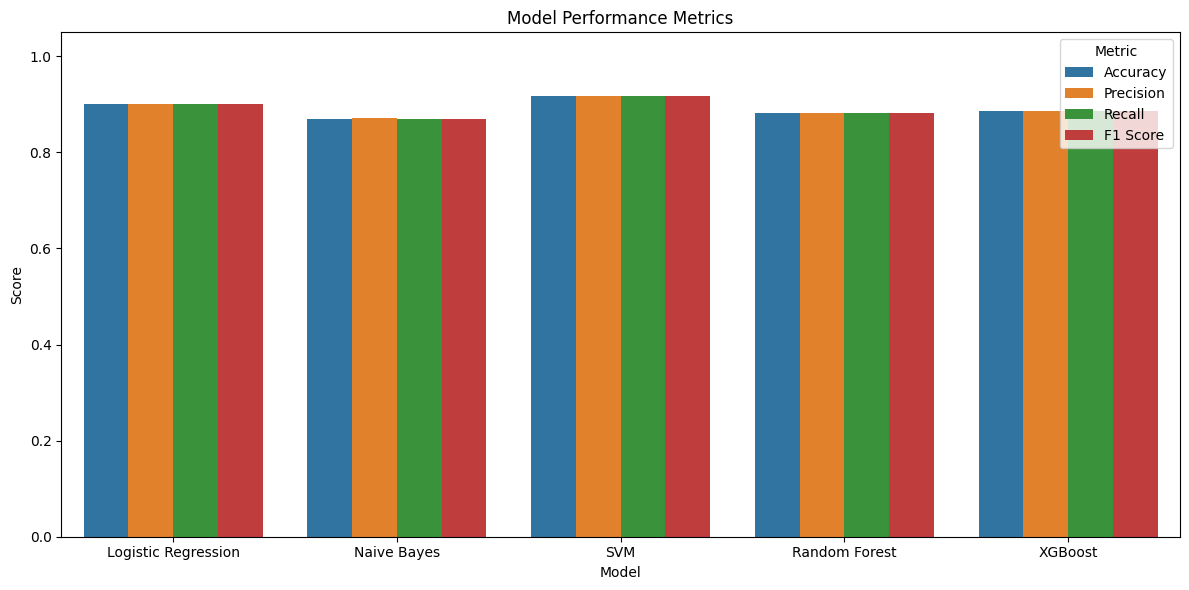

In [27]:
# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df.melt(id_vars="Model", value_vars=["Accuracy", "Precision", "Recall", "F1 Score"]),
    x="Model", y="value", hue="variable"
)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

In [43]:
best_model_name = "Logistic Regression"
best_model = trained_models[best_model_name]

In [44]:
import joblib

# Save the best model
joblib.dump(best_model, f"{best_model_name}_model.pkl")

# Save the TF-IDF vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [45]:
import joblib

def predict_text(text, model_name="nextspet"):
    # Load the vectorizer and the model
    vectorizer = joblib.load("tfidf_vectorizer.pkl")
    model = joblib.load(f"{model_name}_model.pkl")  # Use model_name variable to dynamically load

    # Transform the input text using the loaded vectorizer
    vect_text = vectorizer.transform([text])

    # Make prediction and return the result
    return model.predict(vect_text)[0]


In [46]:
joblib.dump(best_model, "nextspet_model.pkl")

['nextspet_model.pkl']

In [49]:
text = "This is a new review text."
prediction = predict_text(text, model_name="nextspet")

# Mapping 0 and 1 to their meanings
label_mapping = {0: "Fake Review/ Computer Generated", 1: "Genuine Review"}

print(f"Input Text: {text}")
print(f"Predicted Label: {prediction} ({label_mapping.get(prediction, 'Unknown')})")


Input Text: This is a new review text.
Predicted Label: 0 (Fake Review/ Computer Generated)


In [50]:
text = "I absolutely loved this product! The quality was top-notch, shipping was fast, and customer support was very helpful. Highly recommend to everyone."
prediction = predict_text(text, model_name="nextspet")

label_mapping = {0: "Fake Review", 1: "Genuine Review"}

print(f"Input Text: {text}")
print(f"Predicted Label: {prediction} ({label_mapping.get(prediction, 'Unknown')})")


Input Text: I absolutely loved this product! The quality was top-notch, shipping was fast, and customer support was very helpful. Highly recommend to everyone.
Predicted Label: 0 (Fake Review)


# **MODEL M3 REPORT**
✅ Chosen Model:
Logistic Regression

✅ Scores:

Accuracy: 90.04%

Precision: 90.05%

Recall: 90.04%

F1 Score: 90.04%

✅ Saved Files:

Model: logistic_model.pkl

Vectorizer: tfidf_vectorizer.pkl

✅ Prediction Function:

python
Copy code
def predict_text(text, model_name="logistic"):
    vectorizer = joblib.load("tfidf_vectorizer.pkl")
    model = joblib.load(f"{model_name}_model.pkl")
    vect_text = vectorizer.transform([text])
    return model.predict(vect_text)[0]
✅ Meaning of Predictions:

0 → Fake Review

1 → Genuine Review